In [2]:
import sys
sys.path.append('../../')

In [3]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
SYMBOL

{'XAUUSD': {'H1': 'XAUUSD/XAUUSD_H1 - XAUUSD_H1',
  'H4': 'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
  'D1': 'XAUUSD/XAUUSD_D1 - XAUUSD_D1'}}

In [5]:
XAUUSD = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['D1'] +'.csv',index_col='Time',parse_dates=True)
XAUUSD.index.name = None

In [51]:
start_date = '2007-01-01'
end_date = '2008-01-01'

In [52]:
XAUUSD =  XAUUSD.loc[start_date:end_date]

In [6]:
XAUUSD

,Open,High,Low,Close,Volume
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379
2023-03-09,1815.195,1835.565,1811.805,1831.415,1366


In [7]:
XAUUSD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


In [8]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose',
                   'Low-PrevClose']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis=1)
    return df

In [14]:
class Momentum(Strategy) :
    ATR_SL = 6
    max_dir_count = 2
    count_ATR = 20
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, self.count_ATR)['ATR']
        self.data.df['direction'] = np.where(self.data.Close > self.data.Open, 'bull', 'bear')
        self.data.df['dir_count'] = self.data.df.groupby((self.data.df['direction'] != self.data.df['direction'].shift(1)).cumsum()).cumcount()+1
    

    def next(self):
        current_dir_count = self.data.df.loc[self.data.df.index[-1], 'dir_count']
        current_direction = self.data.df.loc[self.data.df.index[-1], 'direction']
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if current_dir_count >= self.max_dir_count and current_direction == 'bull' and not self.position and not np.isnan(current_ATR):
            if self.position.is_long :
                print('Have a order')
            tp = self.data.Close[-1] + current_ATR * self.ATR_SL
            sl = self.data.Open[-1]  - 0.001
              
                # Place your buy logic here
            
            self.buy(sl=sl, tp=tp, size=1)
        if current_dir_count >= self.max_dir_count and current_direction == 'bear' and not self.position and not np.isnan(current_ATR):
            tp = self.data.Close[-1] - current_ATR * self.ATR_SL
            sl = self.data.Open[-1] + 0.001
               
            
           
            self.sell(sl=sl, tp=tp, size=1)

In [16]:
bt = Backtest(XAUUSD, Momentum, cash=20000, margin=1/2000, )
start = bt.run()
start

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   88.082491
Equity Final [$]                   19436.2294
Equity Peak [$]                    20318.3702
Return [%]                          -2.818853
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    -0.14278
Volatility (Ann.) [%]                0.911034
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.012349
Avg. Drawdown [%]                   -0.413309
Max. Drawdown Duration     5323 days 00:00:00
Avg. Drawdown Duration      309 days 00:00:00
# Trades                                  500
Win Rate [%]                              9.2
Best Trade [%]                      17.196177
Worst Trade [%]                     -9.888391
Avg. Trade [%]                    

In [59]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='1407', ...)

In [25]:
optimize, heatmap =  bt.optimize(
    ATR_SL = range(4,12,1),
    max_dir_count = range(1,10,1),
    maximize='Sharpe Ratio',
    return_heatmap= True,
    

)

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\backtesting.py:1487: UserWarning: Searching for best of 1080 configurations.
  output = _optimize_grid()


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
optimize

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   32.659131
Equity Final [$]                   20411.7995
Equity Peak [$]                     20653.864
Return [%]                           2.058998
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.101896
Volatility (Ann.) [%]                0.553251
Sharpe Ratio                         0.184176
Sortino Ratio                        0.265912
Calmar Ratio                         0.086773
Max. Drawdown [%]                   -1.174274
Avg. Drawdown [%]                   -0.187945
Max. Drawdown Duration     1247 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                  304
Win Rate [%]                        14.473684
Best Trade [%]                      11.096806
Worst Trade [%]                     -9.888391
Avg. Trade [%]                    

In [24]:
optimize['_strategy']

<Strategy Momentum(ATR_SL=9,max_dir_count=3,count_ATR=16)>

In [22]:
heatmap

ATR_SL  max_dir_count  count_ATR
4       4              8            0.184176
5       5              5            0.000000
        8              11           0.000000
6       1              18           0.115995
        6              14           0.000000
9       5              19           0.000000
Name: Sharpe Ratio, dtype: float64

In [52]:
hm = heatmap.groupby(["ATR_SL","max_dir_count"]).mean().unstack()

In [53]:
hm

max_dir_count,1,2,3,4,5,6,7,8,9
ATR_SL,,,,,,,,,
1,30.04335,31.9503,29.99210,29.99850,76.96435,71.03985,73.57730,88.7303,73.65
2,25.10570,28.5262,31.55560,40.33650,84.49030,138.01510,76.93780,98.7366,73.65
3,24.38755,25.0415,31.76570,146.96710,200.30615,145.42280,88.12370,98.8329,73.65
4,30.16000,28.0852,30.06660,227.31120,357.09120,98.19520,68.60980,108.7082,73.65
5,31.19450,20.6590,24.96550,323.67850,855.39275,154.34700,73.37575,118.7145,73.65
6,24.97670,23.2894,28.49540,380.07030,855.70270,174.37860,78.14170,67.6020,73.65
7,26.54480,24.1198,31.11230,797.14185,1299.18675,226.76385,51.69000,67.6020,73.65
8,30.55460,30.8062,31.63820,703.56760,951.85140,336.53640,51.69000,67.6020,73.65
9,26.67290,24.3056,32.03160,243.99975,730.04955,271.12905,51.69000,67.6020,73.65


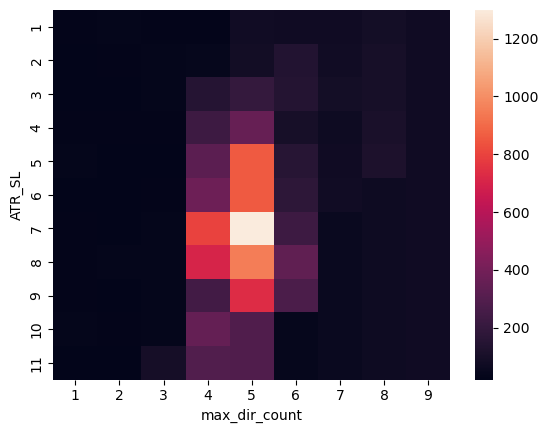

In [56]:
sns.heatmap(hm)
plt.show()

In [61]:
plot_heatmaps(heatmap, agg='mean',filename='../Strategy+8+-+Momentum.ipynb/Momentum_plot_heatmaps_.html')

Column(id='5715', ...)

In [31]:
bt.plot()

Row(id='4467', ...)